In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import boxcox
from scipy.special import inv_boxcox
plt.rc('font', family='NanumBarunGothic') 

In [2]:
data = pd.read_csv('Auction_master_train.csv')

### 이상치 제거

In [3]:
def outlier(data):
    q1, q3 = np.percentile(data,[25,75])
    iqr = q3-q1
    lb = q1 - (iqr*1.5)
    ub = q3 + (iqr*1.5)
    
    return np.where((data>ub)|(data<lb))

tmp = data['addr_si'].unique()
data = data.reset_index()

d = []
for i in tmp:
    ind = outlier(data[data['addr_si']==i]['Hammer_price'])
    ind2 = list(data[data['addr_si']==i].iloc[ind[0],:]['index'])
    if len(ind2) != 0 :
        d = d+ind2

data = data.drop(index=d)

## 날짜 관련 파생변수 생성

In [4]:
from datetime import datetime
data['First_auction_date'] = data['First_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))
data['Final_auction_date'] = data['Final_auction_date'].apply(lambda x : datetime.strptime(x.split(' ')[0],"%Y-%m-%d"))

data['Final_First_auction_data'] = data['Final_auction_date']-data['First_auction_date'] #최종경매일, 최초경매일 일수 차이
data['Final_First_auction_data'] = data['Final_First_auction_data'].astype('timedelta64[D]').astype(int)

## 필요없는 column 떨구기

In [5]:
data.columns

Index(['index', 'Auction_key', 'Auction_class', 'Bid_class', 'Claim_price',
       'Appraisal_company', 'Appraisal_date', 'Auction_count',
       'Auction_miscarriage_count', 'Total_land_gross_area',
       'Total_land_real_area', 'Total_land_auction_area',
       'Total_building_area', 'Total_building_auction_area',
       'Total_appraisal_price', 'Minimum_sales_price', 'First_auction_date',
       'Final_auction_date', 'Final_result', 'Creditor', 'addr_do', 'addr_si',
       'addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Apartment_usage', 'Preserve_regist_date', 'Total_floor',
       'Current_floor', 'Specific', 'Share_auction_YorN', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x', 'Hammer_price', 'Final_First_auction_data'],
      dtype='object')

In [6]:
data = data.drop(['index','Auction_key','Auction_class', 'Bid_class','Appraisal_date','Auction_miscarriage_count',
                  'First_auction_date',
       'Final_auction_date', 'Final_result', 'Creditor','addr_dong', 'addr_li', 'addr_san', 'addr_bunji1', 'addr_bunji2',
       'addr_etc', 'Apartment_usage', 'Preserve_regist_date','Specific', 'Share_auction_YorN', 'road_name',
       'road_bunji1', 'road_bunji2', 'Close_date', 'Close_result', 'point.y',
       'point.x'],axis=1)

## 변수 고치기(?)

#### **1)addr_si - 시군구**

In [7]:
def get_quantile(data):
    q1, q2, q3 = np.percentile(data,[25,50,75])
    return [min(data),q1,q2,q3,max(data)]

df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['addr_si']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

df['addr_si'] = tmp

In [8]:
import scipy.cluster.hierarchy as shc
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from matplotlib import pyplot as plt

In [9]:
cluster = linkage(df.iloc[:,:-1],method='average')
from sklearn.cluster import AgglomerativeClustering

cluster = AgglomerativeClustering(n_clusters=4, linkage='average') 
pred = cluster.fit_predict(df.iloc[:,:-1])

df['addr_si_cluster'] = pred

data = pd.merge(data,df[['addr_si','addr_si_cluster']],how='left',on ='addr_si')

data = data.join(pd.get_dummies(data['addr_si_cluster'],prefix='ad_si'))

#### **2)Appraisal_company - 감정사**

In [10]:
tmp = data['Appraisal_company'].unique()

df = pd.DataFrame(columns=['min','q1','q2','q3','max'])
for i in tmp:
    price = data[data['Appraisal_company']==i]['Hammer_price']
    df = df.append(pd.Series(get_quantile(price),index=df.columns),ignore_index=True)

df['Appraisal_company'] = tmp

cluster = linkage(df.iloc[:,:-1],method='average')

cluster = AgglomerativeClustering(n_clusters=3, linkage='average')
pred = cluster.fit_predict(df.iloc[:,:-1])

df['Appraisal_company_cluster'] = pred

data = pd.merge(data,df[['Appraisal_company','Appraisal_company_cluster']],how='left',on ='Appraisal_company')

data = data.join(pd.get_dummies(data['Appraisal_company_cluster'],prefix='Appr'))

#### **3)addr_do - 시도**

In [11]:
data = data.join(pd.get_dummies(data['addr_do']))

#### **5) Box-Cox Transformation - Y**

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


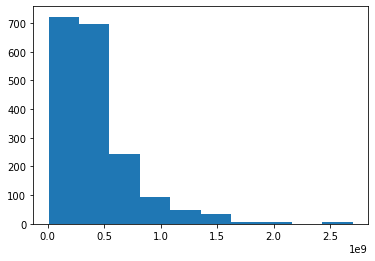

In [12]:
plt.hist(data['Hammer_price'])
plt.show()

In [13]:
lambda_boxcox = boxcox(data['Hammer_price'])[1]
data['Hammer_price'] = boxcox(data['Hammer_price'])[0]

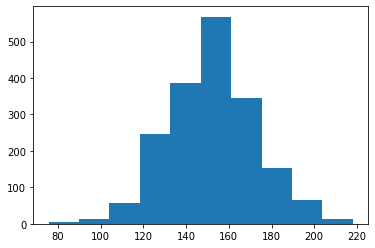

In [14]:
plt.hist(data['Hammer_price'])
plt.show()

In [15]:
# 다시 transformation 이전으로 바꿔주는 함수!!
inv_boxcox(data['Hammer_price'], lambda_boxcox)

0       7.600000e+08
1       9.718900e+08
2       9.340000e+07
3       2.568990e+08
4       1.586600e+08
            ...     
1850    4.025000e+08
1851    4.302346e+08
1852    1.119000e+09
1853    4.030000e+08
1854    6.860100e+08
Name: Hammer_price, Length: 1855, dtype: float64

#### **6) floor -> skyscraper 변수**

In [16]:
dummy = []
for i in range(data.shape[0]):
    dummy.append(max(30,data['Current_floor'][i]))
data['skyscraper'] = dummy

## 마지막으로 떨구고 Y 추가

In [17]:
data = data.drop(['Appraisal_company','addr_do', 'addr_si','Total_floor',
       'Current_floor'],axis=1)

E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 49436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 50872 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 48512 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 49328 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\anaconda3\lib\site-pack

<AxesSubplot:>

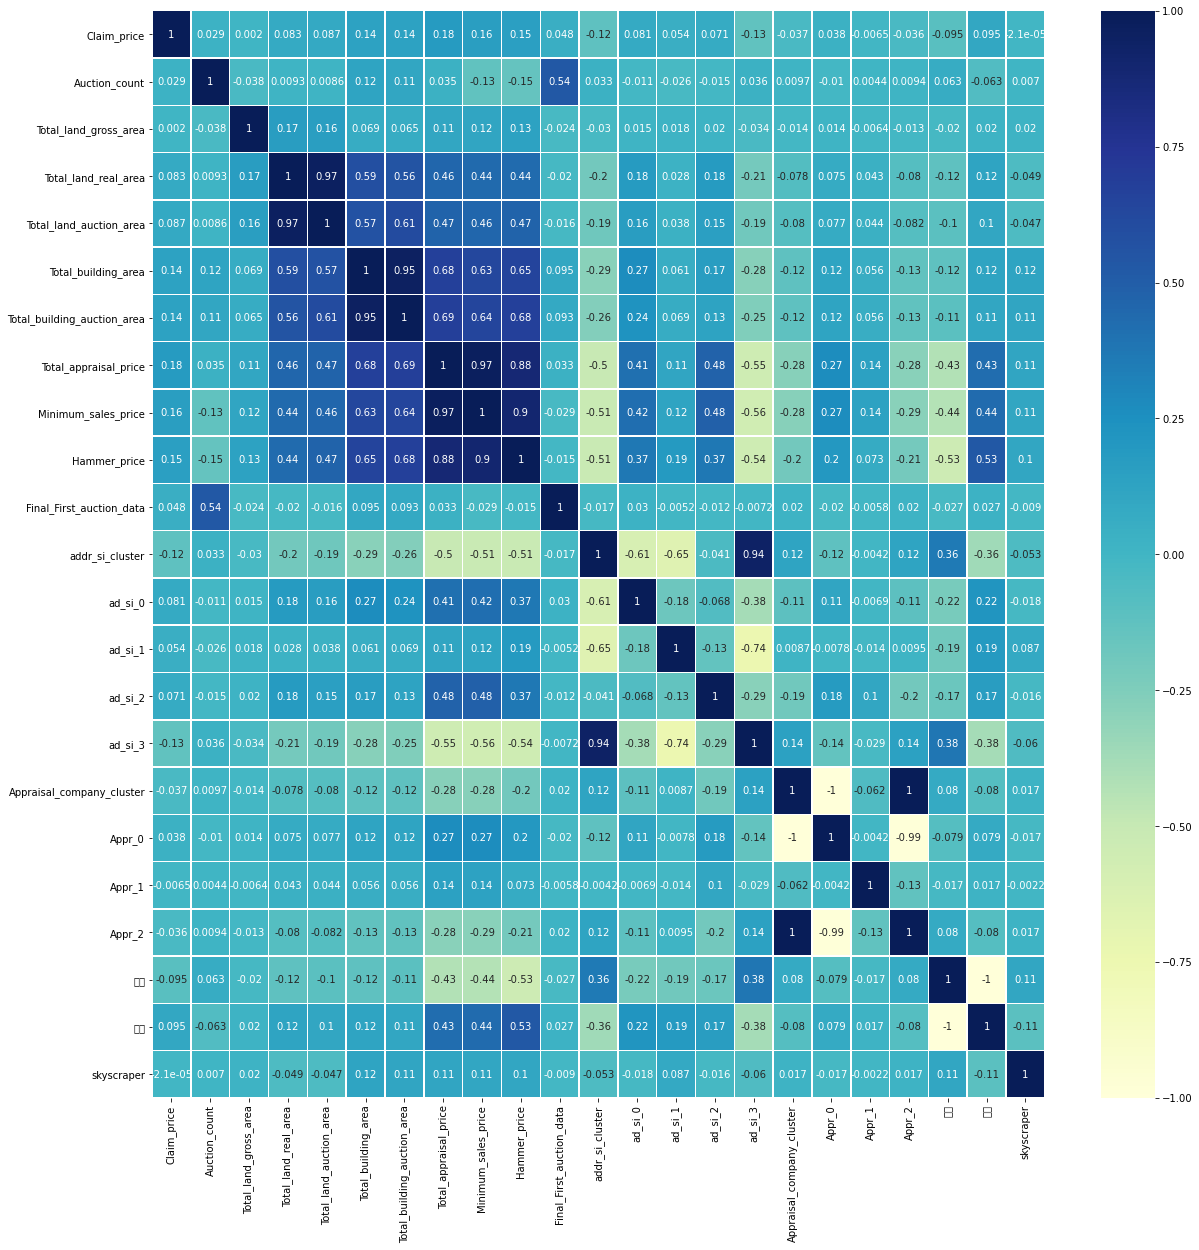

In [18]:
figure,ax1 = plt.subplots()
figure.set_size_inches(20,20)
sns.heatmap(data.corr(),linewidths=0.5,annot=True,cmap='YlGnBu')

## PCA

<AxesSubplot:>

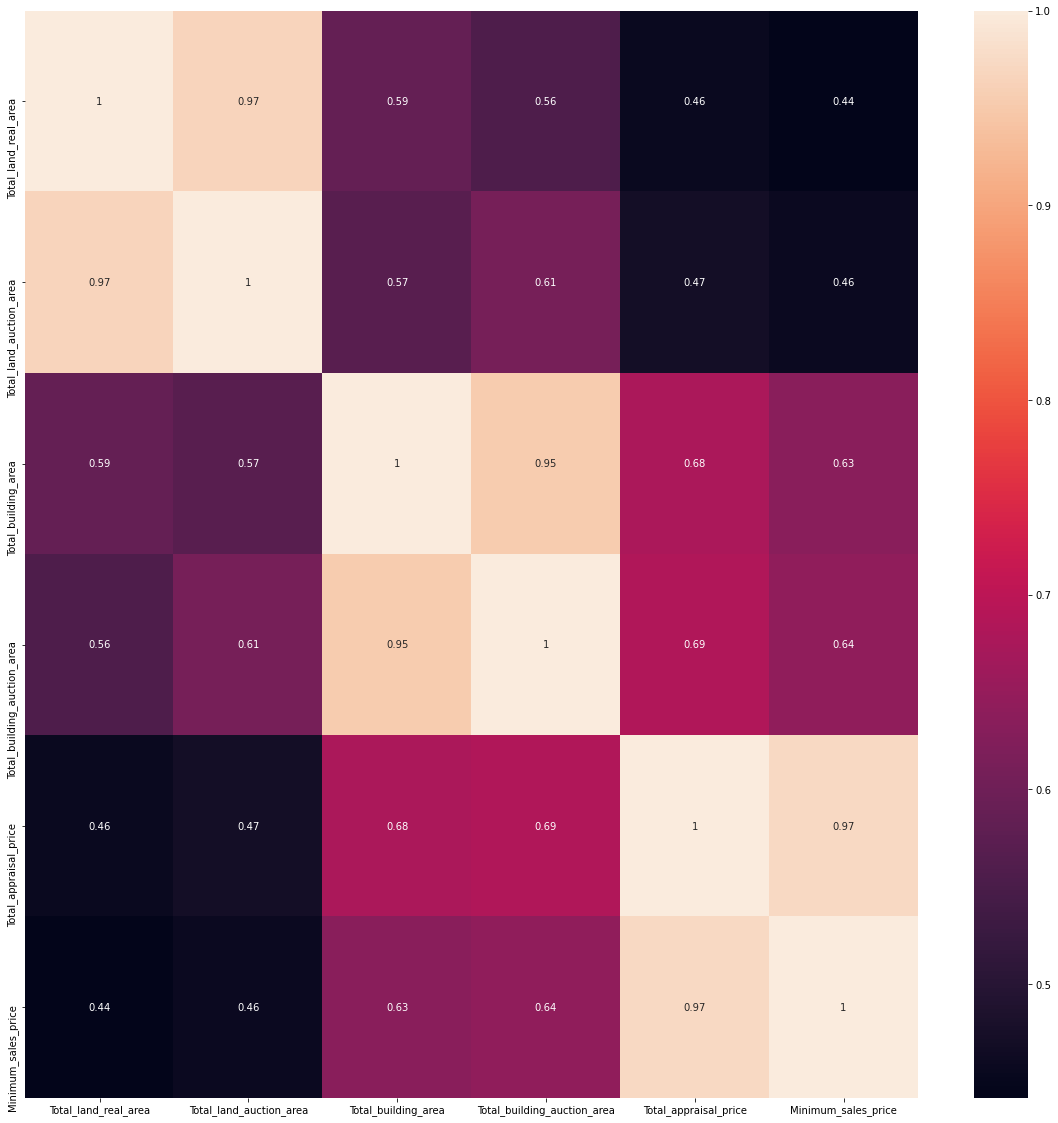

In [19]:
plt.figure(figsize=(20,20))

sns.heatmap(data.iloc[:,3:9].corr(),annot=True)

In [20]:
from sklearn.preprocessing import StandardScaler

data_4pca = data.iloc[:,3:9]

data_scaled = pd.DataFrame(StandardScaler().fit_transform(data_4pca), columns=data_4pca.columns, index = data_4pca.index)

In [21]:
from sklearn.decomposition import PCA
pca = PCA(random_state=2016147006)
X_p = pca.fit_transform(data_scaled)

#Eigenvalue 구하기
from factor_analyzer import FactorAnalyzer

fa = FactorAnalyzer(n_factors=data_scaled.shape[1], rotation= None)
fa.fit(data_scaled)

ev, v = fa.get_eigenvalues()
ev

array([4.23507607e+00, 1.07251766e+00, 5.88342433e-01, 7.57988036e-02,
       2.54122021e-02, 2.85282679e-03])

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


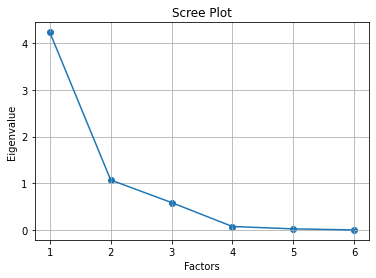

In [22]:
plt.scatter(range(1, data_scaled.shape[1]+1),ev)
plt.plot(range(1,data_scaled.shape[1]+1),ev)
plt.title('Scree Plot')
plt.xlabel('Factors')
plt.ylabel('Eigenvalue')
plt.grid()
plt.show()

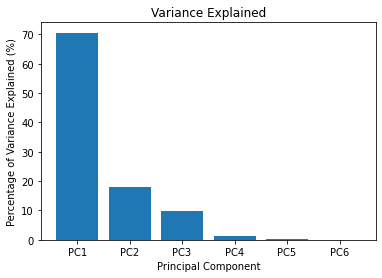

In [23]:
import numpy as np
each_variance_ratio = pca.explained_variance_ratio_

# 누적 분산 설명 비율

cumsum = np.cumsum(pca.explained_variance_ratio_)

pd.Series(np.cumsum(pca.explained_variance_ratio_)) #고유값을 기준으로 설명 가능한 분산 (누적)
percent_variance = np.round(pca.explained_variance_ratio_* 100, decimals =2)
columns = []
for i in range(len(percent_variance)):
    columns.append(f'PC{i+1}')

ax = plt.bar(x = range(len(percent_variance)), height=percent_variance, tick_label=columns)
plt.ylabel('Percentage of Variance Explained (%)')
plt.xlabel('Principal Component')
plt.title('Variance Explained')
plt.show()

In [24]:
pd.DataFrame(pca.components_[:,:2], 
             columns = ['PC1','PC2'], 
             index=data_scaled.columns)

,PC1,PC2
Total_land_real_area,0.381317,0.388127
Total_land_auction_area,0.563714,0.547767
Total_building_area,-0.214817,-0.200224
Total_building_auction_area,0.451076,-0.455970
Total_appraisal_price,-0.005146,0.016151
Minimum_sales_price,-0.535894,0.548680


<AxesSubplot:>

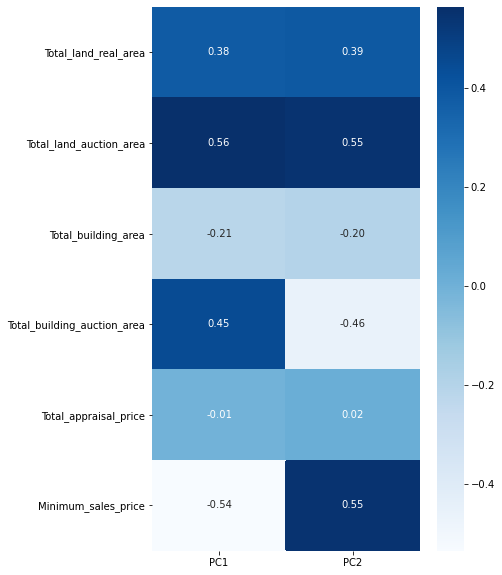

In [25]:
pca_result = pd.DataFrame(pca.components_[:,:2], 
             columns = ['PC1','PC2'], 
             index=data_scaled.columns)
plt.figure(figsize=(6,10))
sns.heatmap(pca_result, cmap="Blues", annot=True, fmt='.2f') #소수 둘째자리까지

In [26]:
X_pca = pca.fit_transform(data_scaled)

X_ppca = pd.DataFrame(X_pca[:,:2],columns=['PC1','PC2'],
                      index = data_scaled.index)

X_ppca

,PC1,PC2
0,2.823222,-1.435719
1,1.278944,-2.646606
2,-0.530059,2.631658
3,-0.706458,0.081095
4,-0.533846,0.986816
...,...,...
1850,-0.078348,0.092530
1851,0.563585,-0.107314
1852,2.107911,-3.202834
1853,-0.112361,0.278945


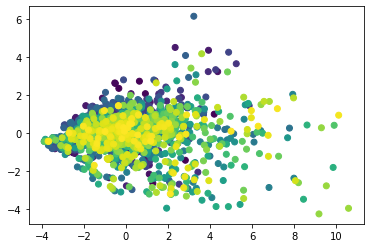

In [27]:
plt.scatter(x=X_ppca['PC1'],y=X_ppca['PC2'], c=X_ppca.index)

## 새롭게 합치기

In [28]:
data = data.drop(['Total_land_real_area', 'Total_land_gross_area',
                  'Total_land_auction_area', 'Total_building_area',
                  'Total_building_auction_area', 'Total_appraisal_price',
                  'addr_si_cluster', 'Appraisal_company_cluster',
                  'Minimum_sales_price', '부산'],axis=1)

In [29]:
data = pd.concat([X_ppca, data],axis=1)

In [30]:
data

,PC1,PC2,Claim_price,Auction_count,Hammer_price,Final_First_auction_data,ad_si_0,ad_si_1,ad_si_2,ad_si_3,Appr_0,Appr_1,Appr_2,서울,skyscraper
0,2.823222,-1.435719,1766037301,2,175.394072,35,0,1,0,0,0,0,1,0,30
1,1.278944,-2.646606,152946867,2,182.985785,35,0,1,0,0,0,0,1,0,51
2,-0.530059,2.631658,11326510,3,121.888773,77,0,0,0,1,0,0,1,0,30
3,-0.706458,0.081095,183581724,2,145.387692,105,0,0,0,1,0,0,1,0,30
4,-0.533846,0.986816,45887671,2,133.700341,28,0,0,0,1,0,0,1,0,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1850,-0.078348,0.092530,280000000,1,157.155252,0,0,0,0,1,0,0,1,1,30
1851,0.563585,-0.107314,200000000,2,158.977901,28,0,0,0,1,0,0,1,1,30
1852,2.107911,-3.202834,354805459,2,187.479268,28,0,1,0,0,0,0,1,1,30
1853,-0.112361,0.278945,80000000,2,157.189024,35,0,0,0,1,0,0,1,1,30


In [31]:
data.corr()['Hammer_price']

PC1                         0.801433
PC2                        -0.368775
Claim_price                 0.154280
Auction_count              -0.145719
Hammer_price                1.000000
Final_First_auction_data   -0.015411
ad_si_0                     0.369572
ad_si_1                     0.189547
ad_si_2                     0.372834
ad_si_3                    -0.544001
Appr_0                      0.197915
Appr_1                      0.072808
Appr_2                     -0.205866
서울                          0.533870
skyscraper                  0.102719
Name: Hammer_price, dtype: float64

## Linear Regression

In [32]:
from statsmodels.formula.api import ols

In [36]:
res = ols('Hammer_price ~ PC1 + PC2 + Claim_price + Auction_count + Final_First_auction_data + ad_si_0 + ad_si_1 + ad_si_2 + Appr_0 + Appr_1 + 서울 + skyscraper',
          data = data).fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1004.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:04:38   Log-Likelihood:                -6356.4
No. Observations:                1855   AIC:                         1.274e+04
Df Residuals:                    1842   BIC:                         1.281e+04
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  138.4719      4.073     34.001      0.000     130.484     146.459
PC1                          7.0462      0.105     66.989      0.000       6.840       7.253
PC2                         -5.4190      0.195    -27.841      0.000      -5.801      -5.037
Claim_price               -1.59e-10    1.6e-10     -0.997      0.319   -4.72e-10    1.54e-10
Auction_count               -3.5842      0.229    -15.655      0.000      -4.033      -3.135
Final_First_auction_data     0.0038      0.001      2.898      0.004       0.001       0.006
ad_si_0                      3.0595      0.763      4.010      0.000       1.563       4.556
ad_si_1                      3.3228      0.441      7.535      0.000       2.458       4.188
ad_si_2                      5.2771      0.956      5.518      0.000       3.401       7.153
Appr_0                      -1.3242      1.029     -1.287      0.198      -3.343       0.694
Appr_1                     -21.1708      7.570     -2.797      0.005     -36.018      -6.324
서울                          10.2006      0.409     24.928      0.000       9.398      11.003
skyscraper                   0.4129      0.132      3.117      0.002       0.153       0.673
==============================================================================
Omnibus:                      554.932   Durbin-Watson:                   2.122
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2222.534
Skew:                          -1.404   Prob(JB):                         0.00
Kurtosis:                       7.568   Cond. No.                     5.03e+10
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.03e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [37]:
res2 = ols('Hammer_price ~ PC1 + PC2 + Auction_count + Final_First_auction_data + ad_si_0 + ad_si_1 + ad_si_2 + Appr_0 + Appr_1 + 서울 + skyscraper',
          data = data).fit()

res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1095.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:05:11   Log-Likelihood:                -6356.9
No. Observations:                1855   AIC:                         1.274e+04
Df Residuals:                    1843   BIC:                         1.280e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  138.3632      4.071     33.986      0.000     130.379     146.348
PC1                          7.0346      0.105     67.292      0.000       6.830       7.240
PC2                         -5.4089      0.194    -27.827      0.000      -5.790      -5.028
Auction_count               -3.5865      0.229    -15.666      0.000      -4.035      -3.137
Final_First_auction_data     0.0038      0.001      2.871      0.004       0.001       0.006
ad_si_0                      3.0427      0.763      3.989      0.000       1.547       4.539
ad_si_1                      3.3059      0.441      7.503      0.000       2.442       4.170
ad_si_2                      5.2602      0.956      5.501      0.000       3.385       7.136
Appr_0                      -1.3189      1.029     -1.281      0.200      -3.337       0.700
Appr_1                     -20.9751      7.568     -2.772      0.006     -35.817      -6.133
서울                          10.1912      0.409     24.912      0.000       9.389      10.994
skyscraper                   0.4154      0.132      3.137      0.002       0.156       0.675
==============================================================================
Omnibus:                      555.406   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2222.982
Skew:                          -1.406   Prob(JB):                         0.00
Kurtosis:                       7.567   Cond. No.                     7.49e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.49e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [38]:
res3 = ols('Hammer_price ~ PC1 + PC2 + Auction_count + Final_First_auction_data + ad_si_0 + ad_si_1 + ad_si_2 + 서울 + skyscraper',
          data = data).fit()

res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           Hammer_price   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.866
Method:                 Least Squares   F-statistic:                     1332.
Date:                Tue, 01 Jun 2021   Prob (F-statistic):               0.00
Time:                        19:05:37   Log-Likelihood:                -6361.5
No. Observations:                1855   AIC:                         1.274e+04
Df Residuals:                    1845   BIC:                         1.280e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                  137.7325      4.070     33.842      0.000     129.750     145.715
PC1                          6.9914      0.103     67.573      0.000       6.788       7.194
PC2                         -5.3327      0.192    -27.715      0.000      -5.710      -4.955
Auction_count               -3.5937      0.229    -15.668      0.000      -4.044      -3.144
Final_First_auction_data     0.0039      0.001      2.942      0.003       0.001       0.006
ad_si_0                      3.1037      0.762      4.071      0.000       1.608       4.599
ad_si_1                      3.3343      0.441      7.555      0.000       2.469       4.200
ad_si_2                      5.0524      0.953      5.303      0.000       3.184       6.921
서울                          10.2332      0.410     24.985      0.000       9.430      11.036
skyscraper                   0.4339      0.132      3.276      0.001       0.174       0.694
==============================================================================
Omnibus:                      551.890   Durbin-Watson:                   2.123
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2194.362
Skew:                          -1.398   Prob(JB):                         0.00
Kurtosis:                       7.535   Cond. No.                     4.02e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.02e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""